# Transfer Learning: DenseNet 121

## Import Dependecies 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from keras.applications import DenseNet121
from keras.applications.densenet import preprocess_input

from keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix

## Load Dataset

In [ ]:
from keras.datasets import cifar10

def load_dataset():
    try:
        (X_train, y_train), (X_test, y_test) = cifar10.load_data()
        return X_train, y_train, X_test, y_test
    except Exception as e:
        raise ValueError(f"Dataset could not be loaded: {e}")

# CALL the function
X_train, y_train, X_test, y_test = load_dataset()

# Now print shapes
print("\n")
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 173s 1us/step


X_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
X_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)


In [ ]:
# Define the classes
class_names = [
    "airplane", "automobile", "bird", "cat",
    "deer", "dog", "frog", "horse",
    "ship", "truck"
]

## Data Preprocessing

### Normalization

In [ ]:
# Apply normalization (scale pixel values from 0–255 to 0–1)

X_train = X_train / 255.0
X_test = X_test / 255.0

# Display RGB pixel values of the first image at position (0, 0)

print("Red  :", X_train[0, 0, 0, 0])   # Red channel value
print("Green:", X_train[0, 0, 0, 1])   # Green channel value
print("Blue :", X_train[0, 0, 0, 2])   # Blue channel value

# Check normalization has applied properly

Red  : 0.23137254901960785
Green: 0.24313725490196078
Blue : 0.24705882352941178


## DenseNet121 Model

**Setup Early Stop & Reduce LR**

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define early stop
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

# Define reduce LR
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-4, verbose=1)


### Build Model

In [ ]:
# Add custom classification layers on top of the pretrained base model
base_model= DenseNet121(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

base_model.trainable = False

model = models.Sequential([

    # layers.inputLayer(input=(32, 32, 3)),

    layers.Resizing(224, 224),   # resize on the fly

    base_model,  # Pretrained DenseNet feature extractor

    layers.GlobalAveragePooling2D(),
    # Converts feature maps into a single feature vector

    layers.Dense(128, activation='relu'),
    # Fully connected layer to learn dataset-specific patterns

    layers.Dense(10, activation='softmax')
    # Output layer for 10 CIFAR classes
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display model architecture
model.build((None, 32, 32, 3))
model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing_3 (Resizing)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169,994 (27.35 MB)

 Trainable params: 132,490 (517.54 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

### Train Model

In [ ]:
print("Input shape:", X_train.shape)
print("Model input shape:", model.input_shape)
print("Label shape:", y_train.shape)

history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=64,
    callbacks=[early_stop, reduce_lr]
)

Input shape: (50000, 32, 32, 3)
Model input shape: (None, 32, 32, 3)
Label shape: (50000, 1)
Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 115s 129ms/step - accuracy: 0.6930 - loss: 0.8984 - val_accuracy: 0.8034 - val_loss: 0.5586 - learning_rate: 0.0010
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 55s 87ms/step - accuracy: 0.8185 - loss: 0.5193 - val_accuracy: 0.8164 - val_loss: 0.5219 - learning_rate: 0.0010
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 54s 87ms/step - accuracy: 0.8368 - loss: 0.4654 - val_accuracy: 0.8197 - val_loss: 0.5114 - learning_rate: 0.0010
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 54s 87ms/step - accuracy: 0.8447 - loss: 0.4412 - val_accuracy: 0.8279 - val_loss: 0.4871 - learning_rate: 0.0010
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 54s 87ms/step - accuracy: 0.8574 - loss: 0.4079 - val_accuracy: 0.8206 - val_loss: 0.5070 - learning_rate: 0.0010
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 54s 87ms/step - accuracy: 0.8585 - loss: 0.4054 - val_accuracy: 0.8405 - val_loss: 0.4662 - lea

In [ ]:
# Predictions
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Evaluate Test Accuacy
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 41s 72ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 34ms/step - accuracy: 0.8329 - loss: 0.4793
Test Accuracy: 0.8370
Test loss: 0.4740


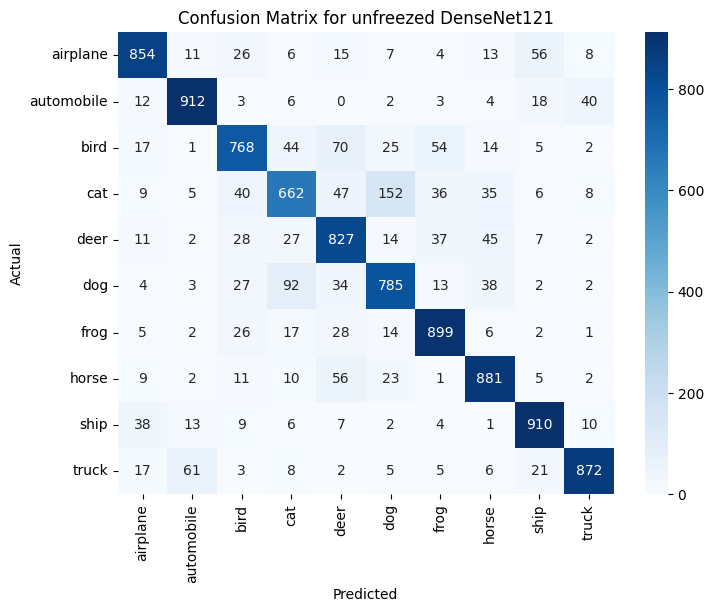

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for unfreezed DenseNet121")
plt.show()

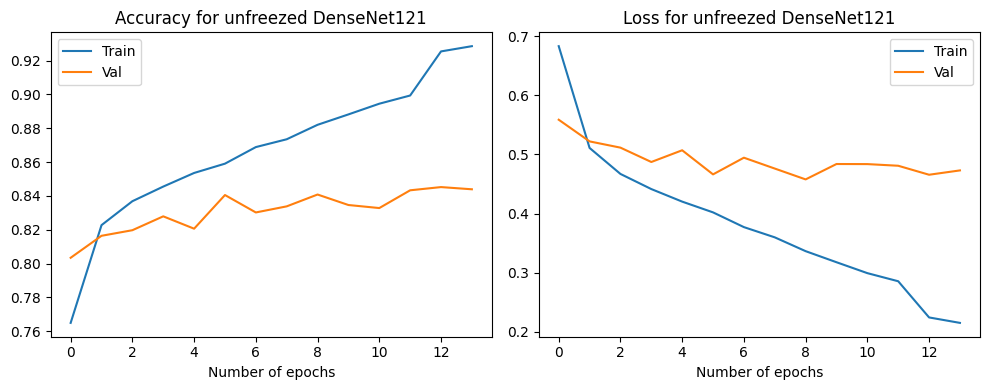

In [ ]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Accuracy for unfreezed DenseNet121", fontsize= 12)
plt.legend(["Train", "Val"])
plt.xlabel("Number of epochs")

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Loss for unfreezed DenseNet121", fontsize = 12)
plt.legend(["Train", "Val"])
plt.xlabel("Number of epochs")

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np

# Training history metrics
epochs_trained = len(history.history["loss"])
best_val_acc = max(history.history["val_accuracy"])
best_epoch = np.argmax(history.history["val_accuracy"]) + 1
final_train_acc = history.history["accuracy"][-1]
final_val_acc = history.history["val_accuracy"][-1]

# Test metrics (already printed)
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)

# Trainable parameters
trainable_params = np.sum(
    [np.prod(v.shape) for v in model.trainable_weights]
)

In [ ]:
results_df = pd.DataFrame([{
    "model_name": "DenseNet121_finetuned",
    "epochs_trained": epochs_trained,
    "best_epoch": best_epoch,
    "best_val_acc": best_val_acc,
    "final_train_acc": final_train_acc,
    "final_val_acc": final_val_acc,
    "test_acc": test_acc,
    "test_loss": test_loss,
    "trainable_params": trainable_params
}])

In [ ]:
results_df

,model_name,epochs_trained,best_epoch,best_val_acc,final_train_acc,final_val_acc,test_acc,test_loss,trainable_params
0,DenseNet121_finetuned,14,13,0.8452,0.928525,0.8439,0.837,0.473967,132490


#### Unfreeze Layers

* We can unfreeze some of the pretrained layers so the model can learn more from the CIFAR dataset and improve its performance.

* It is generally a good practice to unfreeze only the last 15–20% of the layers instead of all layers.

* If we unfreeze all layers at once, it may lead to **catastrophic forgetting**, where the model forgets the useful features it learned from the ImageNet dataset.

* Fine-tuning only a small portion of deeper layers allows the model to adapt while keeping the previously learned general features stable.


In [ ]:
# Unfreeze the layers
base_model.trainable = True

# Freeze all layers except the last 40
fine_tune_at = len(base_model.layers) - 40

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing (Resizing)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169,994 (27.35 MB)

 Trainable params: 960,202 (3.66 MB)

 Non-trainable params: 6,209,792 (23.69 MB)

In [ ]:
history_fine = model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=64, callbacks = [early_stop, reduce_lr])

Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 112s 126ms/step - accuracy: 0.8365 - loss: 0.4845 - val_accuracy: 0.8600 - val_loss: 0.4253 - learning_rate: 0.0010
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 58s 92ms/step - accuracy: 0.9026 - loss: 0.2748 - val_accuracy: 0.8689 - val_loss: 0.4008 - learning_rate: 0.0010
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 57s 91ms/step - accuracy: 0.9303 - loss: 0.1937 - val_accuracy: 0.8806 - val_loss: 0.3789 - learning_rate: 0.0010
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 57s 91ms/step - accuracy: 0.9469 - loss: 0.1470 - val_accuracy: 0.8692 - val_loss: 0.4585 - learning_rate: 0.0010
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 57s 91ms/step - accuracy: 0.9617 - loss: 0.1090 - val_accuracy: 0.8843 - val_loss: 0.4282 - learning_rate: 0.0010
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9664 - loss: 0.0916
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
625/625 ━━━━━━━━━━━━━━━━━━━━ 57s 91ms/step - accuracy: 0.9664 - l

In [ ]:
# Predictions
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Evaluate Test Accuacy
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 35s 73ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 35ms/step - accuracy: 0.8738 - loss: 0.4176
Test Accuracy: 0.8709
Test loss: 0.4239


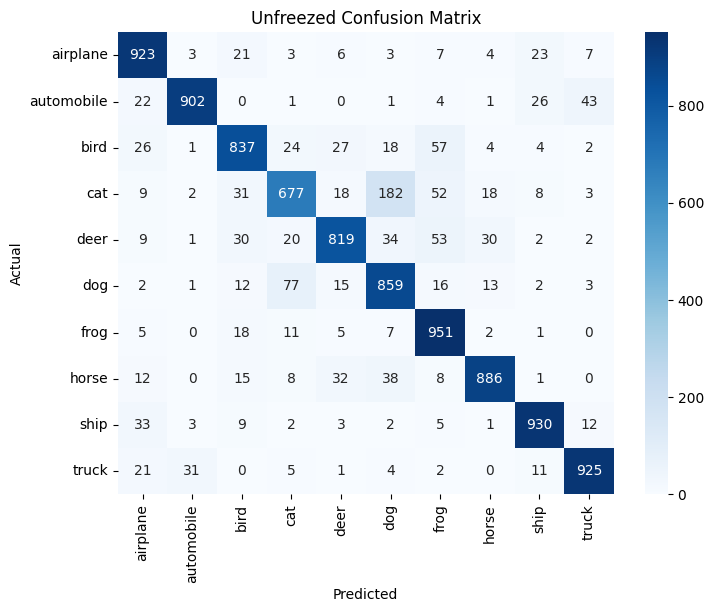

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Unfreezed Confusion Matrix")
plt.show()

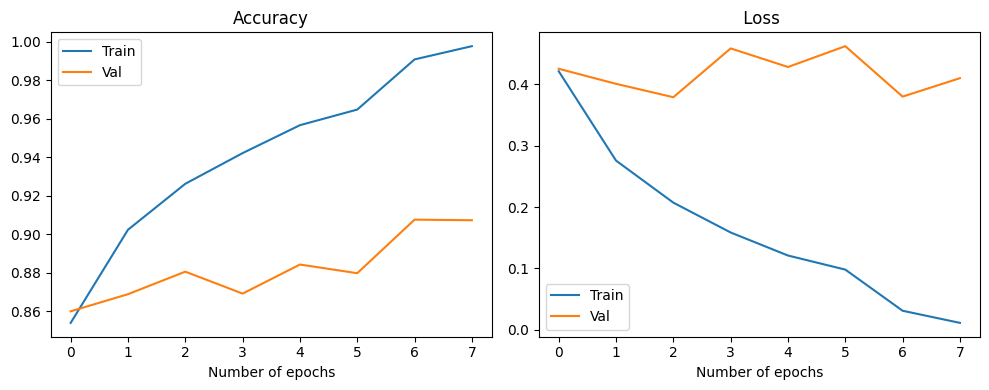

In [ ]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(history_fine.history['accuracy'])
plt.plot(history_fine.history['val_accuracy'])
plt.title("Accuracy")
plt.legend(["Train", "Val"])
plt.xlabel("Number of epochs")

plt.subplot(1,2,2)
plt.plot(history_fine.history['loss'])
plt.plot(history_fine.history['val_loss'])
plt.title(" Loss")
plt.legend(["Train", "Val"])
plt.xlabel("Number of epochs")

plt.tight_layout()
plt.show()

In [ ]:
# Extract fine-tuned metrics
fine_epochs = len(history_fine.history["loss"])
fine_best_val_acc = max(history_fine.history["val_accuracy"])
fine_best_epoch = np.argmax(history_fine.history["val_accuracy"]) + 1
fine_final_train_acc = history_fine.history["accuracy"][-1]
fine_final_val_acc = history_fine.history["val_accuracy"][-1]

fine_test_loss, fine_test_acc = model.evaluate(X_test, y_test, verbose=0)

fine_trainable_params = np.sum(
    [np.prod(v.shape) for v in model.trainable_weights]
)

# Create new row
new_row = pd.DataFrame([{
    "model_name": "unfrozen_densenet",
    "epochs_trained": fine_epochs,
    "best_epoch": fine_best_epoch,
    "best_val_acc": fine_best_val_acc,
    "final_train_acc": fine_final_train_acc,
    "final_val_acc": fine_final_val_acc,
    "test_acc": fine_test_acc,
    "test_loss": fine_test_loss,
    "trainable_params": fine_trainable_params
}])

# Append to existing result_df
results_df = pd.concat([results_df, new_row], ignore_index=True)

print(results_df)

              model_name  epochs_trained  best_epoch  best_val_acc  \
0  DenseNet121_finetuned              14          13        0.8452   
1      unfrozen_densenet               8           7        0.9076   

   final_train_acc  final_val_acc  test_acc  test_loss  trainable_params  
0         0.928525         0.8439    0.8370   0.473967            132490  
1         0.997675         0.9073    0.8709   0.423915            960202  


In [ ]:
results_df

,model_name,epochs_trained,best_epoch,best_val_acc,final_train_acc,final_val_acc,test_acc,test_loss,trainable_params
0,DenseNet121_finetuned,14,13,0.8452,0.928525,0.8439,0.8370,0.473967,132490
1,unfrozen_densenet,8,7,0.9076,0.997675,0.9073,0.8709,0.423915,960202


In [ ]:
# Unfreeze the layers
base_model.trainable = True

# Freeze all layers except the last 40
fine_tune_at = len(base_model.layers) - 40

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing (Resizing)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,169,994 (27.35 MB)

 Trainable params: 960,202 (3.66 MB)

 Non-trainable params: 6,209,792 (23.69 MB)

In [ ]:
history_tune_lr = model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=64, callbacks = [early_stop, reduce_lr])

Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 111s 126ms/step - accuracy: 0.9586 - loss: 0.1236 - val_accuracy: 0.8999 - val_loss: 0.3233 - learning_rate: 1.0000e-05
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 58s 92ms/step - accuracy: 0.9655 - loss: 0.1046 - val_accuracy: 0.9027 - val_loss: 0.3192 - learning_rate: 1.0000e-05
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 57s 91ms/step - accuracy: 0.9721 - loss: 0.0903 - val_accuracy: 0.9040 - val_loss: 0.3181 - learning_rate: 1.0000e-05
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 57s 92ms/step - accuracy: 0.9749 - loss: 0.0823 - val_accuracy: 0.9042 - val_loss: 0.3180 - learning_rate: 1.0000e-05
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 57s 91ms/step - accuracy: 0.9761 - loss: 0.0748 - val_accuracy: 0.9052 - val_loss: 0.3190 - learning_rate: 1.0000e-05
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 57s 91ms/step - accuracy: 0.9791 - loss: 0.0684 - val_accuracy: 0.9054 - val_loss: 0.3209 - learning_rate: 1.0000e-05
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 57s 91ms/s

In [ ]:
# Extract fine-tuned metrics
fine_epochs = len(history_fine.history["loss"])
fine_best_val_acc = max(history_fine.history["val_accuracy"])
fine_best_epoch = np.argmax(history_fine.history["val_accuracy"]) + 1
fine_final_train_acc = history_fine.history["accuracy"][-1]
fine_final_val_acc = history_fine.history["val_accuracy"][-1]

fine_test_loss, fine_test_acc = model.evaluate(X_test, y_test, verbose=0)

fine_trainable_params = np.sum(
    [np.prod(v.shape) for v in model.trainable_weights]
)

# Create new row
new_row = pd.DataFrame([{
    "model_name": "unfrozen_densenet_lr",
    "epochs_trained": fine_epochs,
    "best_epoch": fine_best_epoch,
    "best_val_acc": fine_best_val_acc,
    "final_train_acc": fine_final_train_acc,
    "final_val_acc": fine_final_val_acc,
    "test_acc": fine_test_acc,
    "test_loss": fine_test_loss,
    "trainable_params": fine_trainable_params
}])

# Append to existing result_df
results_df = pd.concat([results_df, new_row], ignore_index=True)

results_df

,model_name,epochs_trained,best_epoch,best_val_acc,final_train_acc,final_val_acc,test_acc,test_loss,trainable_params
0,DenseNet121_finetuned,14,13,0.8452,0.928525,0.8439,0.8370,0.473967,132490
1,unfrozen_densenet,8,7,0.9076,0.997675,0.9073,0.8709,0.423915,960202
2,unfrozen_densenet_lr,8,7,0.9076,0.997675,0.9073,0.8935,0.351445,960202
